## SVD for Recommender Systems



One of the most used techniques for recommender system based on user ratings, is the SVD Matrix Factorization. 
This method constructs a matrix with the row of users and columns of items and the elements are given by the users ratings. Singular value decomposition decomposes a matrix into three other matrices and extracts the factors from the factorization of a user-item-rating matrix:

$$ A = USV^T $$



$U$: singular matrix of user-latent factors.        
$S$: diagonal matrix shows the strength of each latent factor.        
$V$: singular matrix of item-latent factors



The final output of the matrix $A$ (in a principle of $m*n$ dimension)reduces the dimension through latent factors’ extraction. From the matrix $A$, it shows the relationships between users and items by mapping the user and item into r-dimensional latent space. Vector $X_i$ is considered each item and vector $Y_u$ is regarded as each user. The rating is given by a user on an item as $R_{ui}$ = $X^T_i$ * $Y_u$. The loss can be minimized by the square error difference between the product of $R_{ui}$ and the expected rating.

$$ Min(x,y) \sum_{u,i \in\ K}(r_{ui} - x^T_i.y_u)^2 $$

Adding the $λ$ regularization term to avoid overfitting:

$$ Min(x,y) \sum_{u,i \in\ K}(r_{ui} - x^T_i.y_u)^2 + λ(\Vert x_i \Vert^2 + \Vert y_u \Vert^2)$$


Finally, by adding the corresponding bias terms:


$$ Min(x,y) \sum_{u,i \in\ K}(r_{ui} - x^T_i.y_u - μ - b_i - b_u)^2 + λ(\Vert x_i \Vert^2 + \Vert y_u \Vert^2 + b_i^2 + b_u^2)$$

With:

$(u,i)$: user-item pair.               
$μ$: average rating of all items.             
$b_i$: average rating of item $i$ minus $μ$.            
$b_u$:  average rating given by user $u$ minus $μ$.






## SVD Implementation with Surprise

The Surprise library will be used to build a recommender system:

Detailed documentations of the SVD module in Surprise can be found [here](http://surpriselib.com/).
Source codes of the SVD implementation is available on the Surprise Github repository, which can be found [here](https://github.com/NicolasHug/Surprise).

### Movielens Dataset

The problem dataset is Movielens; it has ratings (1 to 5) from users about movies, and has the format allowed by surpise: three colums reprensenting the user-id, item-id and the rating (in this order).


In [4]:
pip install surprise


     |████████████████████████████████| 11.8 MB 23.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623221 sha256=8ea48702430dc4b8767dfd6fa10c065f6c55a7aa2993cecd1608b46ac2fad8dd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [5]:
pip install recommenders

     |████████████████████████████████| 318 kB 18.6 MB/s 
     |████████████████████████████████| 3.4 MB 59.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 636 kB 56.0 MB/s 
     |████████████████████████████████| 12.4 MB 55.3 MB/s 
     |████████████████████████████████| 310 kB 64.8 MB/s 
     |████████████████████████████████| 61 kB 8.3 MB/s 
     |████████████████████████████████| 191 kB 54.9 MB/s 
     |████████████████████████████████| 1.5 MB 50.5 MB/s 
     |████████████████████████████████| 93 kB 2.4 MB/s 
     |████████████████████████████████| 749 kB 50.4 MB/s 
     |████████████████████████████████| 376 kB 58.8 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 3.3 MB 48.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705347 sha256=1cbaf774cf1349bc876609965b7922812d7da

In [62]:
import surprise
import pandas as pd
import numpy as np
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions

In [51]:
data = movielens.load_pandas_df(
    size='1M',
    header=["userID", "itemID", "rating"]
)

data.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 24.0kKB/s]


,userID,itemID,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


Check not null data

In [52]:
sum(data.isnull().any())

0

Check not duplicated data


In [53]:
sum(data.duplicated(['userID','itemID','rating']))

0

In [54]:
print("Total n° of ratings: ", data.shape[0])
print("Total n° of users: ", len(np.unique(data['userID'])))
print("Total n° of movies: ", len(np.unique(data['itemID'])))

Total n° of ratings:  1000209
Total n° of users:  6040
Total n° of movies:  3706


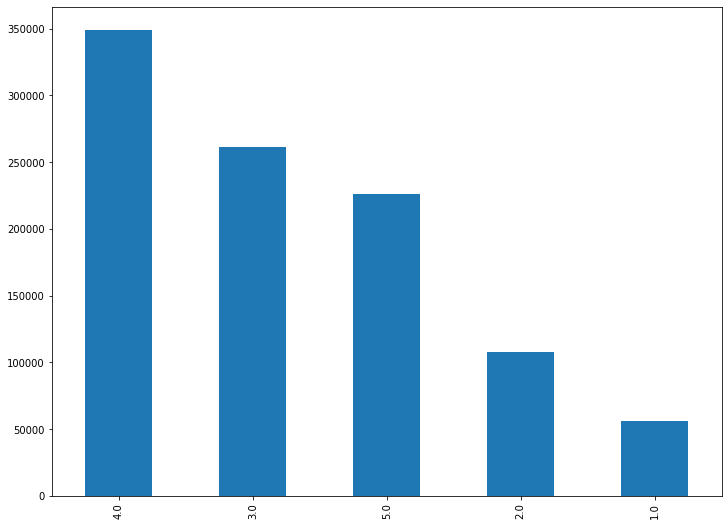

In [55]:
data['rating'].value_counts().sort_values(ascending=False).plot(kind='bar',figsize=(12,9))

In [56]:
train, test = python_random_split(data, 0.75)

In [57]:
# 'reader' get rating scale.
train_set = surprise.Dataset.load_from_df(train, reader=surprise.Reader('ml-100k')).build_full_trainset()


## Fit

The model will be fitted with n_factors = 100 (the number of factors of the SVD factorization) and with 25 epochs.


In [58]:
svd = surprise.SVD(random_state=2022, n_factors=100, n_epochs=25, verbose=True)

with Timer() as train_time:
    svd.fit(train_set)

print("Took {} seconds for training.".format(train_time.interval))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Took 56.99759201100005 seconds for training.


## Predictions

In [59]:
predictions = predict(svd, test, usercol='userID', itemcol='itemID')
predictions.head()

,userID,itemID,prediction
0,5412,2683,3.640839
1,5440,904,5.000000
2,368,3717,3.097441
3,425,1721,3.638913
4,4942,3697,2.671762


#### Removing items seen for each user

In [60]:
with Timer() as test_time:
    all_predictions = compute_ranking_predictions(svd, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
print("Took {} seconds for prediction.".format(test_time.interval))

Took 231.09962418799978 seconds for prediction.


## Performance Metrics

In [63]:
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)



print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae, sep='\n')
     



RMSE:		0.883953
MAE:		0.692644


It is seen that the RMSE and MAE are pretty low, indicating that on average the error in the predicted ratings is less than 1. The RMSE is a bit higher, because high errors are penalized much more for squares property.


### Exploring movie similarity (with cosine similarity) and SVD factorization with linalg

In [64]:
#first the matrix should be built with the items as rows
#and the users as columns

matrix_t = np.ndarray(
    shape=(np.max(data.itemID.values), np.max(data.userID.values)),
    dtype=np.uint8)
matrix_t[data.itemID.values-1, data.userID.values-1] = data.rating.values #the ids starts at 1
    


In [65]:
#normalize values
matrix_normalised = matrix_t - np.asarray([(np.mean(matrix_t, 1))]).T

In [66]:
A = matrix_normalised.T / np.sqrt(matrix_t.shape[0] - 1)
U, S, V = np.linalg.svd(A)

In [67]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [68]:
#load movie_data to know which id identifies each movie(find movies.dat in data folder)
movie_data = pd.io.parsers.read_csv('/gdrive/MyDrive/movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

In [98]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [90]:
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[1:top_n + 1] #the first one always will be the same movie

In [91]:
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])

In [95]:
k = 50
movie_id = 1 # Toy Story
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)

In [96]:
print_similar_movies(movie_data, movie_id, indexes)

Recommendations for Toy Story (1995): 

Babe (1995)
Lion King, The (1994)
Mask, The (1994)
Firm, The (1993)
Beauty and the Beast (1991)
Twister (1996)
Rock, The (1996)
Outbreak (1995)
Clear and Present Danger (1994)
GoldenEye (1995)


In [101]:
movie_data[movie_data.title=="Star Wars: Episode VI - Return of the Jedi (1983)"]

,movie_id,title,genre
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War


In [103]:
k = 50
movie_id = 1210 #Star Wars Episode VI- Return of the Jedi
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)
print_similar_movies(movie_data, movie_id, indexes)

Recommendations for Star Wars: Episode VI - Return of the Jedi (1983): 

Star Wars: Episode V - The Empire Strikes Back (1980)
Raiders of the Lost Ark (1981)
Indiana Jones and the Last Crusade (1989)
Terminator, The (1984)
Predator (1987)
Aliens (1986)
Back to the Future (1985)
Robocop (1987)
E.T. the Extra-Terrestrial (1982)
Star Trek: The Wrath of Khan (1982)


In [97]:
movie_data[movie_data.title=="Pulp Fiction (1994)"]

,movie_id,title,genre
293,296,Pulp Fiction (1994),Crime|Drama


In [104]:
k = 50
movie_id = 296 #Pulp Fiction
top_n = 10
sliced = V.T[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)
print_similar_movies(movie_data, movie_id, indexes)

Recommendations for Pulp Fiction (1994): 

Fargo (1996)
Silence of the Lambs, The (1991)
Seven (Se7en) (1995)
Usual Suspects, The (1995)
Schindler's List (1993)
Twelve Monkeys (1995)
Dances with Wolves (1990)
True Lies (1994)
Forrest Gump (1994)
Star Wars: Episode IV - A New Hope (1977)
